In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../../code/')

import itertools
import seaborn as sns
import reframed
import scipy.stats as st
from scipy.stats import linregress
import leakage
sns.set_theme(font_scale = 1, style = 'ticks')


# Description
The goal of this notebook is to see wheter differences in metabolite values are indicative of differences in metabolite release rates


In [53]:
model_folder = Path('../../../models/e_coli/')
model_fn  =  model_folder / 'momentiJO1366_modified.xml'
model_ec = reframed.load_cbmodel(model_fn)

In [54]:
div_folder = Path('../../../data/this_project/5_div/')
mapping_fn = div_folder / '5A_metabolomics_name_to_bigg.csv'
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

In [55]:
git_folder = Path('../../../')
data_folder = git_folder / 'data'
# fn = git_folder / 'data' / 'other'/'A_rates_and_values.csv'
sintef_fn = data_folder / 'this_project' / '1_e_coli_batch_cultures'/'1K_rates_and_values.csv'#'sintef_2023/sintef_2023_rates_1024.csv'

df_rates = pd.read_csv(sintef_fn, index_col=0)

In [56]:
# Drop rows where no rate is measured
df_rates = df_rates.dropna(subset=['Slope'])

In [57]:
carbon_sources = df_rates['Carbon source'].unique()


In [58]:
df_rates['Metabolite ID'] = df_rates['Metabolite'].map(mapping_dict)

# Estimate metabolite release for the different metabolites

In [59]:
metabolites = [f'M_{m}_c' for m in df_rates['Metabolite ID'].unique()]
metabolite_ids = [m for m in metabolites if m in model_ec.metabolites]

In [60]:

uptake_rates = {'Glucose': -7.04,
                'Galactose': -4.3,
                'L-alanine': -17.25,
                'L-malate': -16.5}

cs_to_exchange = {
        'Galactose': 'R_EX_gal_e',
        'L-malate': 'R_EX_mal__L_e',
        'L-alanine': 'R_EX_ala__L_e',
        'Glucose': 'R_EX_glc__D_e'}

In [61]:
shadow_prices = {}
for cs, uptake_rate in uptake_rates.items():
    print(f'Carbon source: {cs}, uptake rate: {uptake_rate} mmol/gDW/h')
    exchange_id = cs_to_exchange[cs]
    shadow_prices[cs] = leakage.estimate_shadow_prices_reframed(model_ec, constraints={exchange_id: (uptake_rate,0)}, metabolites = metabolite_ids)

Carbon source: Glucose, uptake rate: -7.04 mmol/gDW/h
8/76: M_glc__D_c, predicted flux: -7.04, secretion reaction: R_EX_glc__D_e
Carbon source: Galactose, uptake rate: -4.3 mmol/gDW/h
Carbon source: L-alanine, uptake rate: -17.25 mmol/gDW/h
6/76: M_ala__L_c, predicted flux: -7.167287619143618, secretion reaction: R_EX_ala__L_e
Carbon source: L-malate, uptake rate: -16.5 mmol/gDW/h
4/76: M_ac_c, predicted flux: 0.320435385908489, secretion reaction: R_EX_ac_e
43/76: M_mal__L_c, predicted flux: -15.525389391381147, secretion reaction: R_EX_mal__L_e


In [62]:
shadow_prices_df = pd.DataFrame(shadow_prices).T

In [63]:
shadow_prices_df.columns = [x[2:-2] for x in shadow_prices_df.columns]

In [64]:
diff = []

for cs1, cs2 in itertools.combinations(carbon_sources, 2):
    if cs1 != cs2:
        
        diff_ij = shadow_prices_df.loc[cs1] - shadow_prices_df.loc[cs2]
        log1  = np.log10(-shadow_prices_df.loc[cs1])
        log2  = np.log10(-shadow_prices_df.loc[cs2])
        diff.append([cs1,cs2, diff_ij, log1-log2])

In [65]:
# Assuming diff is a list of [cs1, cs2, diff_ij] where diff_ij is a Series or array with metabolite names as index
diff_df = pd.DataFrame([
    {'Carbon source 1': cs1, 'Carbon source 2': cs2, 'Metabolite': met, 'Diff': val}
    for cs1, cs2, diff_ij,_ in diff
    for met, val in diff_ij.items()
])

log_diff_df = pd.DataFrame([
    {'Carbon source 1': cs1, 'Carbon source 2': cs2, 'Metabolite': met, 'Log Diff': val}
    for cs1, cs2, _, log_diff_ij in diff
    for met, val in log_diff_ij.items()
])

display(diff_df.head())

,Carbon source 1,Carbon source 2,Metabolite,Diff
0,Galactose,L-malate,23dhb,-0.014270
1,Galactose,L-malate,ghb,-0.036035
2,Galactose,L-malate,34hpp,-0.049767
3,Galactose,L-malate,ac,-0.019974
4,Galactose,L-malate,aicar,-0.009311


In [66]:
df_rates.columns

Index(['Carbon source', 'Metabolite', 'Slope', 'Intercept', 'r', 'p-value',
       'Std. Err', 'N', 'T3_pval', 'Fitted on', 'Comment', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Rate [1/gDW/h]', 'Std. Err [1/gDW/h]',
       'Metabolite value [gDW/mmol]', 'N carbons', 'Mol weight [g/mol]',
       'Turnover [mmol/gDW/h]', 'Model ID', 'MV min', 'MV max', 'Species',
       'Dataset', 'Metabolite ID'],
      dtype='object')

In [67]:
# Difference in rates
metabolites_short = [m[2:-2] for m in metabolites]
rate_diff = []
for cs1, cs2 in itertools.combinations(carbon_sources, 2):
    for met in metabolites_short:
        if cs1 != cs2:
            idx1 = (df_rates['Carbon source'] == cs1) & (df_rates['Metabolite ID'] == met)
            idx2 = (df_rates['Carbon source'] == cs2) & (df_rates['Metabolite ID'] == met)
            if idx1.any() and idx2.any():
                if df_rates.loc[idx1, 'Fitted on'].values[0] != df_rates.loc[idx2, 'Fitted on'].values[0]:
                    print(f'Skipping {cs1} vs {cs2} for {met} due to different fitting methods')
                    continue
                else:
                    slope1 = df_rates.loc[idx1, 'Slope'].values[0]
                    slope2 = df_rates.loc[idx2, 'Slope'].values[0]
                    pvalue1 = df_rates.loc[idx1, 'p-value'].values[0]
                    pvalue2 = df_rates.loc[idx2, 'p-value'].values[0]
                    rate_diff.append({
                        'Carbon source 1': cs1,
                        'Carbon source 2': cs2,
                        'Metabolite': met,
                        'Rate Diff': slope1 - slope2,
                        'p-value 1': pvalue1,
                        'p-value 2': pvalue2,
                        'slope 1': slope1,
                        'slope 2': slope2,
                        'Log rate diff': np.log10(slope1) - np.log10(slope2)
                    })
rate_diff_df = pd.DataFrame(rate_diff)

Skipping Galactose vs L-malate for icit due to different fitting methods
Skipping Galactose vs L-malate for lac__D due to different fitting methods
Skipping Galactose vs L-alanine for icit due to different fitting methods
Skipping Galactose vs L-alanine for lys__L due to different fitting methods
Skipping Galactose vs L-alanine for ser__L due to different fitting methods
Skipping L-malate vs L-alanine for lac__D due to different fitting methods
Skipping L-malate vs L-alanine for lys__L due to different fitting methods
Skipping L-malate vs L-alanine for ser__L due to different fitting methods


/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_19569/3414081576.py:27: RuntimeWarning: invalid value encountered in log10
  'Log rate diff': np.log10(slope1) - np.log10(slope2)


In [68]:
one_positive = (rate_diff_df['slope 1']>0) | (rate_diff_df['slope 2']>0)
two_positive = (rate_diff_df['slope 1']>0) & (rate_diff_df['slope 2']>0)
# rate_diffr_df = rate_diff_df.loc[one_positive]
rate_diffr_df = rate_diff_df.loc[two_positive]

In [69]:
mdiff = pd.merge(diff_df, rate_diffr_df, on=['Carbon source 1', 'Carbon source 2', 'Metabolite'])
mdiff = pd.merge(mdiff, log_diff_df, on=['Carbon source 1', 'Carbon source 2', 'Metabolite'])

In [70]:
mdiff = mdiff.dropna(subset=['Diff', 'Rate Diff'])

In [71]:
significant = mdiff[(mdiff['p-value 1'] < 0.05) & (mdiff['p-value 2'] < 0.05)]

In [72]:
st.pearsonr(significant['Log Diff'], significant['Log rate diff'])

PearsonRResult(statistic=np.float64(-0.34506056399943924), pvalue=np.float64(0.0016062336878324061))

In [73]:
spear_r, spear_p = st.spearmanr(significant["Log Diff"], significant["Log rate diff"])
pear_r, pear_p = st.pearsonr(significant["Log Diff"], significant["Log rate diff"])

In [74]:
spear_p, pear_p, spear_r, pear_r

(np.float64(0.00014450864467177715),
 np.float64(0.0016062336878324061),
 np.float64(-0.40991418247515804),
 np.float64(-0.34506056399943924))

In [75]:
significant['CS1-CS2'] = significant['Carbon source 1'] + ' - ' + significant['Carbon source 2']

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_19569/2430915865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant['CS1-CS2'] = significant['Carbon source 1'] + ' - ' + significant['Carbon source 2']


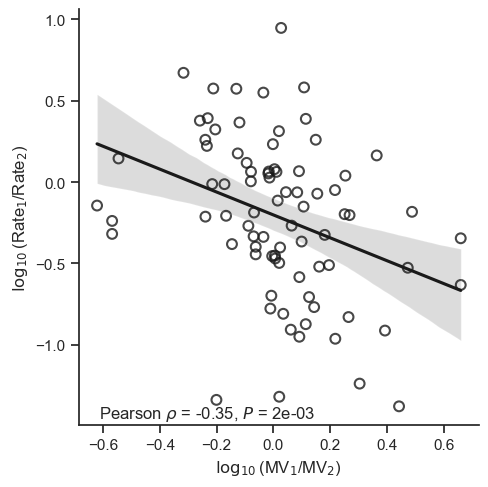

In [76]:
sns.lmplot(data=significant, x='Log Diff', y='Log rate diff', markers='o', 
           scatter_kws={'facecolor': 'none', 'color': 'k', 'linewidths':1.5, 's':50}, line_kws= {'color':'k'}, aspect=1.0, height=5)
plt.xlabel(r'$\log_{10}$(MV$_1$/MV$_2$)')
plt.ylabel(r'$\log_{10}$(Rate$_1$/Rate$_2$)')
# plt.title('Correlation between metabolite value and release rate differences')

plt.annotate(fr'Pearson $\rho$ = {pear_r:.2f}, $P$ = {pear_p:.0e}',
             xy=(0.05, 0.05), xycoords='axes fraction', fontsize=12,
             ha='left', va='top')
plt.savefig(git_folder/'figures'/'cs_met_val_rate_diff.png', dpi=300, bbox_inches='tight')


In [77]:
idx01 = (significant['Log rate diff']>0)&(significant['Log Diff']>0)
idx10 = (significant['Log rate diff']<0)&(significant['Log Diff']<0)
print((idx01 | idx10).sum()/ len(significant))


0.345679012345679


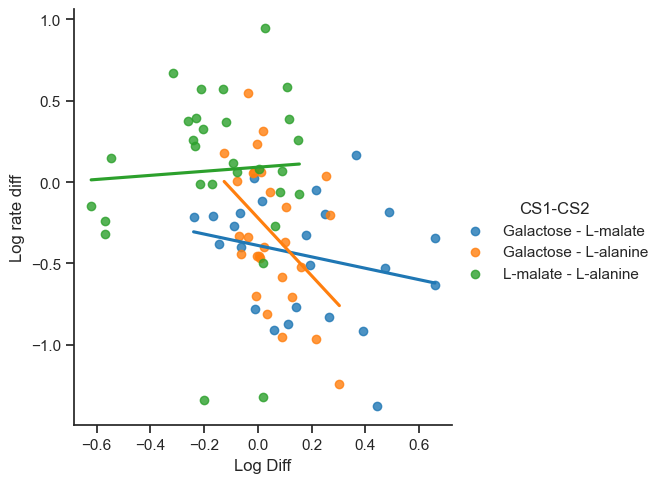

In [78]:
sns.lmplot(data=significant, x='Log Diff', y='Log rate diff', hue='CS1-CS2', palette='tab10', markers='o', ci=None)

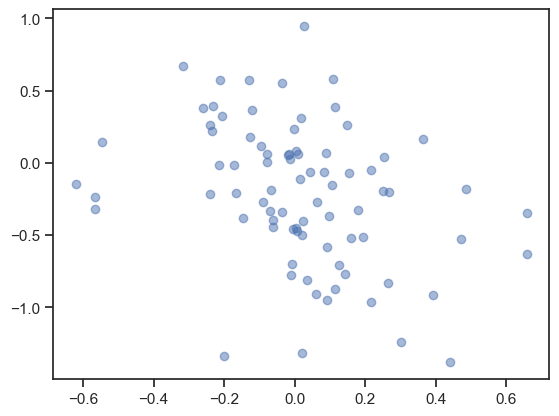

In [79]:
plt.scatter(x = significant['Log Diff'], y  = significant['Log rate diff'], alpha=0.5)
# plt.yscale('log')
# plt.xscale('log')

# Merge mapping dicts

In [80]:
mapping_dict2 = pd.read_csv(div_folder / '5A_metabolomics_name_to_bigg_2.csv', index_col = 0).to_dict()['Metabolite ID']

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/this_project/5_div/5A_metabolomics_name_to_bigg_2.csv'

In [ ]:
for k, v in mapping_dict2.items():
    try:
        v0 = mapping_dict[k]
    except KeyError:
        mapping_dict[k] = v
        print(f'Added {k} to mapping_dict with value {v}')
    else:    
        if (v0 != v) and not np.isnan(v0):
            print(v, v0)
            print(f'Warning: {k} has different values in mapping_dict: {v0}')
        else:
            pass
            # print(f'No change for {k} in mapping_dict, keeping value {v0}')
            # mapping_dict[k] = v

Added 1,3-diaminopropane to mapping_dict with value 13dampp
Added 2,5-dihydroxybenzoate to mapping_dict with value 23dhb
Added 2-aminoisobutyrate to mapping_dict with value nan
Added 2-hydroxybutyrate to mapping_dict with value ghb
Added 2-hydroxyglutaric acid to mapping_dict with value S2hglut
Added 3-(4-hydroxyphenyl)pyruvate to mapping_dict with value 34hpp
Added 3-hydroxyanthranilate to mapping_dict with value nan
Added 3-hydroxybutyrate to mapping_dict with value ghb
Added 3-hydroxyglutaric acid to mapping_dict with value S2hglut
Added 3-hydroxyphenylacetate to mapping_dict with value nan
Added 4-acetamidobutanoate to mapping_dict with value 4aabutn
Added 4-imidazoleacetate to mapping_dict with value im4ac
Added Adenosine to mapping_dict with value and
Added Adenosine 3',5'-cyclic phosphate to mapping_dict with value 23camp
Added Adipate to mapping_dict with value nan
Added Aicar to mapping_dict with value aicar
Added Allantoin to mapping_dict with value alltn
Added Alpha-glucose 

In [ ]:
new_mapping = pd.DataFrame.from_dict(mapping_dict, orient='index')
new_mapping.columns = ['BiGG ID']
new_mapping.index.name = 'Metabolite'
new_mapping = new_mapping.reset_index()
new_mapping = new_mapping.sort_values(by='Metabolite')
new_mapping.to_csv(div_folder / '5A_metabolomics_name_to_bigg_3.csv', index=False)

# Delete below

In [ ]:

df_rates = df_rates.loc[~df_rates['Rate [mmol/gDW/h]'].isna()]

# Read in models

In [ ]:
models = {}
for model_name, model_fn in model_fns.items():
    print(f'Processing {model_name}')
    model = reframed.load_cbmodel(model_fn)
    models[model_name] = model
    model.solver = 'gurobi'
    print(reframed.FBA(model, constraints={'R_EX_glc__D_e': -10}))


Processing eciJO1366
Objective: 0.7044734318697953
Status: Optimal

Processing iJO1366
Objective: 0.9823718127269787
Status: Optimal

Processing iAF1260
Objective: 0.8855712275999393
Status: Optimal

Processing iML1515
Objective: 0.8769972144269733
Status: Optimal

Processing iJR904
Objective: 0.921948095050471
Status: Optimal



In [ ]:
df_rates['Carbon source'].unique()

array(['Glucose', 'Galactose', 'L-malate', 'L-alanine', 'D-Glucose',
       'L-Malate', 'D-Fructose', 'D-Galactose', 'D-Ribose', 'L-Arabinose',
       'Glycerol', 'Pyruvate', 'Succinate', 'Fumarate', 'Acetate'],
      dtype=object)

In [ ]:
df_rates = df_rates.loc[df_rates.Species == 'E. coli']


In [ ]:
df_rates['Metabolite id']

15         2pg
33         3pg
42          ac
43          ac
44          ac
        ...   
768        ura
806     val__L
808     val__L
809     val__L
824    xu5p__D
Name: Metabolite id, Length: 133, dtype: object

In [ ]:
shadow_prices = {}
for model_name, model in models.items():
    model_metabolites = [model.metabolites[m].id for m in model.metabolites]
    for condition, _ in conditions:
        metabolites = df_rates.loc[df_rates['Carbon source']== condition, 'Metabolite id'].values
        metabolite_ids = [f'M_{m_id}_c' for m_id in metabolites  if isinstance(m_id, str)]
        metabolite_ids = [m_id for m_id in metabolite_ids if m_id in model_metabolites]
        print(f'Processing {model_name}, {condition}')
        exchange_id = cs_to_exchange[condition]
        uptake_rate = uptake_rates[(condition, 'E. coli')]
        shadow_prices[(model_name, condition)] = leakage.estimate_shadow_prices_reframed(model, constraints={exchange_id: (uptake_rate,0)}, metabolites = metabolite_ids)
    

Processing eciJO1366, Glucose
Processing eciJO1366, Galactose
Processing eciJO1366, L-alanine
Processing eciJO1366, L-malate
Processing iJO1366, Glucose
Processing iJO1366, Galactose
Processing iJO1366, L-alanine
Processing iJO1366, L-malate
Processing iAF1260, Glucose
Processing iAF1260, Galactose
Processing iAF1260, L-alanine
Processing iAF1260, L-malate
Processing iML1515, Glucose
Processing iML1515, Galactose
Processing iML1515, L-alanine
Processing iML1515, L-malate
Processing iJR904, Glucose
Processing iJR904, Galactose
Processing iJR904, L-alanine
Processing iJR904, L-malate


In [ ]:
# Convert the nested dict to a DataFrame
df_shadow = pd.DataFrame.from_dict(shadow_prices, orient='index').reset_index()
df_shadow = df_shadow.rename(columns={'level_0': 'Model', 'level_1': 'Condition'})

# Melt to long format
df_long = df_shadow.melt(id_vars=['Model', 'Condition'], var_name='Metabolite abbrv.', value_name='Shadow price')


In [ ]:
df_long['log10(Met. value)'] = np.log10(-df_long['Shadow price'])
df_long['log10(Met. value)'] = df_long['log10(Met. value)'].replace([np.inf, -np.inf], np.nan)

/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# First, extract the metabolite id from df_long['Metabolite']
df_long['Metabolite id'] = df_long['Metabolite abbrv.'].str.replace('^M_|_c$', '', regex=True)

# Now merge on 'Metabolite id' and 'Condition' (df_long) <-> 'Metabolite id' and 'Carbon source' (df_rates)
df_long = df_long.merge(
    df_rates[['Metabolite id', 'Carbon source', 'Rate [mmol/gDW/h]', 'Metabolite', 'log10(Rate [mmol/gDW/h])']],
    left_on=['Metabolite id', 'Condition'],
    right_on=['Metabolite id', 'Carbon source'],
    how='left'
)

In [ ]:
df_long.dropna(subset= ['log10(Met. value)', 'log10(Rate [mmol/gDW/h])'], inplace=True)

In [ ]:
# Drop metabolite values < 1e-5
print(len(df_long))
df_long = df_long[df_long['log10(Met. value)'] > -5]
print(len(df_long))

462
461


In [ ]:
fit_data = []
for model_name, _ in models.items():
    for condition, _ in conditions:
        dfi = df_long[(df_long['Model'] == model_name) & (df_long['Condition'] == condition)].copy()
        dfi.dropna(subset=['log10(Met. value)', 'log10(Rate [mmol/gDW/h])'], inplace=True)
        logx = dfi['log10(Met. value)']
        logy = dfi['log10(Rate [mmol/gDW/h])']
        slope, intercept, rvalue, pvalue, _ = linregress(logx,logy)
        pearson_r, pearson_p = st.pearsonr(logx, logy)
        fit_data.append({
            'Model': model_name,
            'Condition': condition,
            'slope': slope,
            'intercept': intercept,
            'rvalue': rvalue,
            'pvalue': pvalue,
            'pearson_r': pearson_r,
            'pearson_p': pearson_p
        })
fit_df = pd.DataFrame(fit_data)


In [ ]:
# 1. Add a rank/order column for the momentiJO1366 model
df_long['Order'] = np.nan
for condition in df_long['Condition'].unique():
    mask = (df_long['Model'] == 'eciJO1366') & (df_long['Condition'] == condition)
    met_to_order = df_long[mask].set_index('Metabolite').groupby(['Condition'])['log10(Met. value)'].rank(method='first')
    condition_mask = df_long['Condition'] == condition
    df_long.loc[condition_mask, 'Order'] = df_long.loc[condition_mask, 'Metabolite'].map(met_to_order)


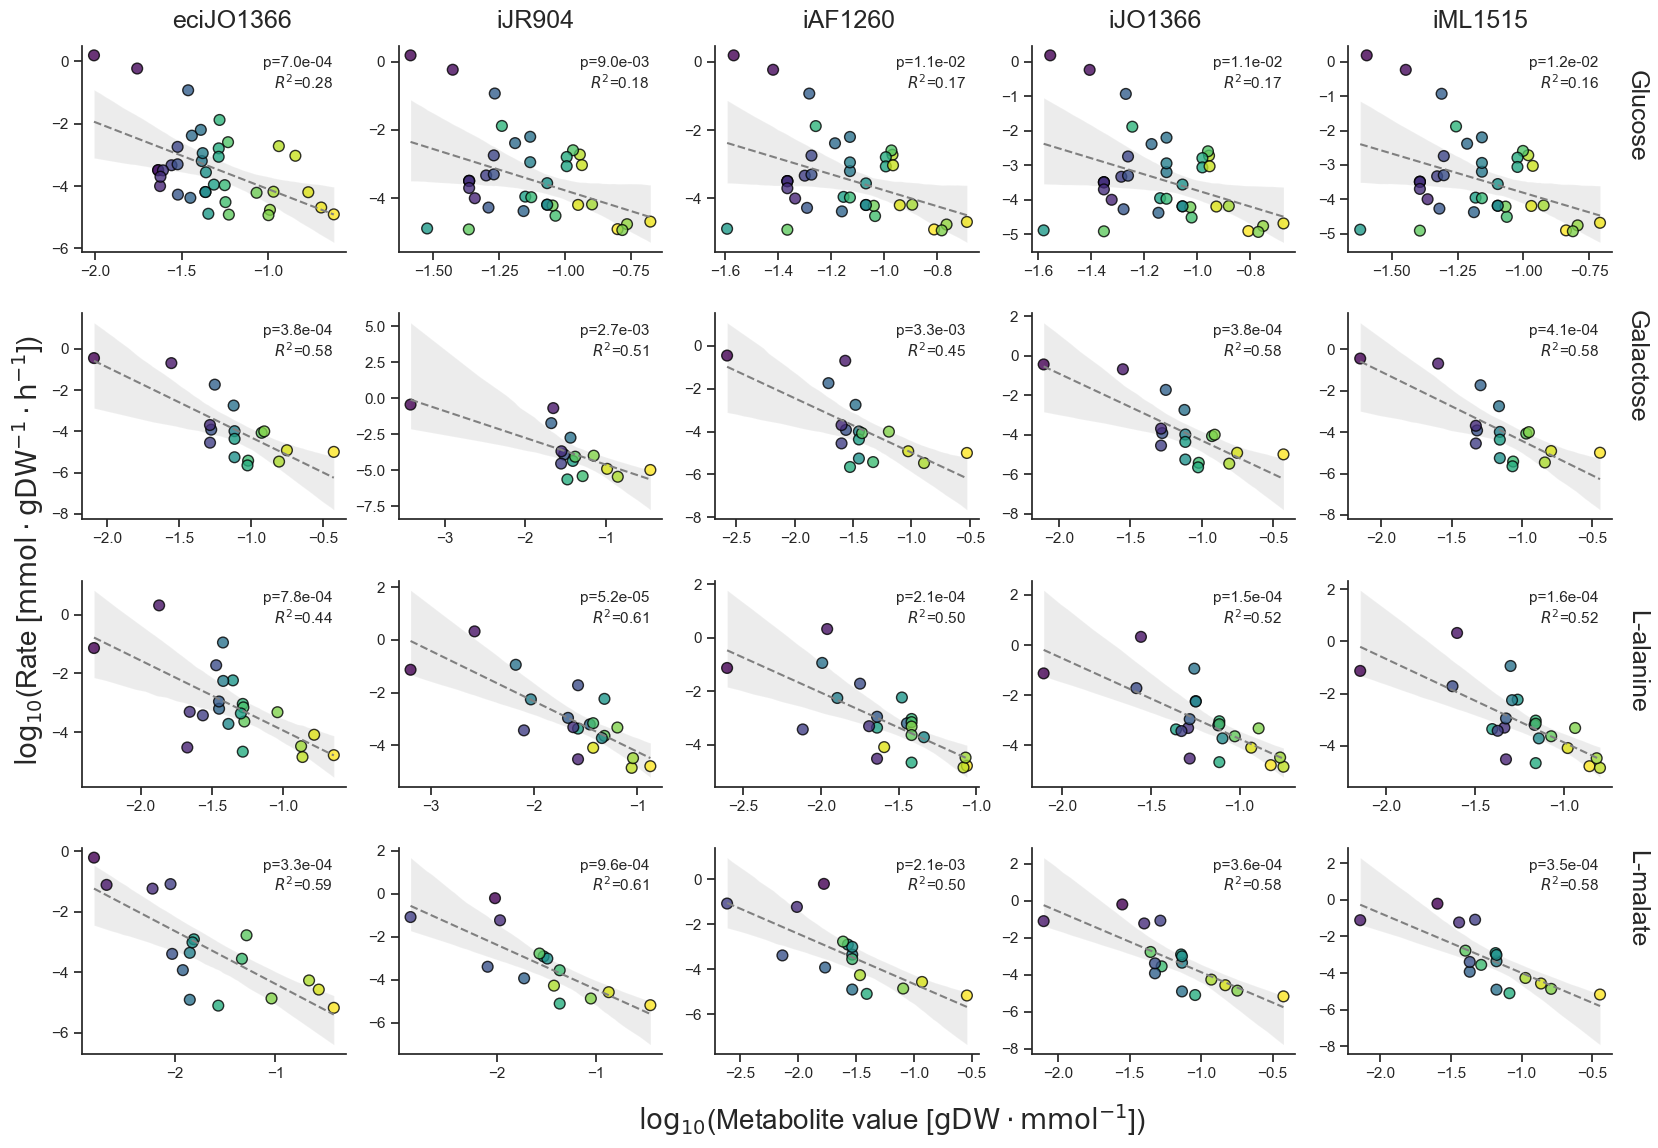

In [ ]:
model_order = ['eciJO1366', 'iJR904', 'iAF1260','iJO1366','iML1515']
g = sns.lmplot(
    data=df_long,
    x='log10(Met. value)', y='log10(Rate [mmol/gDW/h])',
    col='Model', row='Condition', 
    # hue = 'Order',
    facet_kws={'sharex': False, 'sharey': False},
    height=3, aspect=1.2,
    col_order=model_order,
    scatter=False,
    line_kws={'color': 'grey', 'ls': '--', 'lw': 1.5},
)
# Use scatterplot with hue='order' and a continuous palette
for i, col_axes in enumerate(g.axes):
    for j, ax in enumerate(col_axes):
        model_name = g.col_names[j]
        condition = g.row_names[i]
        condition_df = df_long[(df_long['Model'] == model_name) & (df_long['Condition'] == condition)]
        if not condition_df.empty:
            sns.scatterplot(
                data=condition_df, x='log10(Met. value)', y='log10(Rate [mmol/gDW/h])',
                hue='Order', palette='viridis', ax=ax, legend=False, s=60, alpha=0.8, edgecolor='black', linewidth=1
            )

            
g.set_titles("")
g.set_axis_labels('','')
fig = g.fig
fig.supylabel(r'$\rm{log}_{10}$(Rate [$\rm{mmol \cdot gDW^{-1} \cdot h^{-1}}$])', x = 0.01, size = 20)

fig.supxlabel(r'$\rm{log}_{10}$(Metabolite value [$\rm{gDW \cdot mmol^{-1}}$])', y = 0.01, size = 20)
sns.despine()


# After plotting with lmplot
for ax in g.axes.flat:
    # Get current row and col values for this subplot
    row_val = ax.get_subplotspec().rowspan.start
    col_val = ax.get_subplotspec().colspan.start
    # Get the corresponding row/col names
    row_name = g.row_names[row_val]
    col_name = g.col_names[col_val]
    # Find the fit result for this subplot
    fit = fit_df[(fit_df['Model'] == col_name) & (fit_df['Condition'] == row_name)]
    if not fit.empty:
        rho = fit['pearson_r'].values[0]
        pval = fit['pearson_p'].values[0]
        ax.text(
            0.95, 0.95,
            f"p={pval:.1e}\n$R^2$={fit['rvalue'].values[0]**2:.2f}",#$\\rho$={rho:.2f}\n
            transform=ax.transAxes,
            ha='right', va='top', fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

title_size = 18
plt.text(0.1, 0.95, g.col_names[0], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)
plt.text(0.28, 0.95, g.col_names[1], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)
plt.text(0.45, 0.95, g.col_names[2], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)
plt.text(0.62, 0.95, g.col_names[3], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)
plt.text(0.8, 0.95, g.col_names[4], transform=fig.transFigure, ha='left', va='top', fontsize=title_size)

plt.text(0.92, 0.9, g.row_names[0], transform=fig.transFigure, ha='right', va='top', fontsize=title_size, rotation=270)
plt.text(0.92, 0.7, g.row_names[1], transform=fig.transFigure, ha='right', va='top', fontsize=title_size, rotation=270)
plt.text(0.92, 0.45, g.row_names[2], transform=fig.transFigure, ha='right', va='top', fontsize=title_size, rotation=270)
plt.text(0.92, 0.25, g.row_names[3], transform=fig.transFigure, ha='right', va='top', fontsize=title_size, rotation=270)

plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.2, left=0.05, right=0.9, bottom=0.08)
plt.savefig(git_folder / 'figures' / 'all_ecoli_models_rates_vs_metabolite_values.pdf', bbox_inches='tight')
plt.savefig(git_folder / 'figures' / 'all_ecoli_models_rates_vs_metabolite_values.png', bbox_inches='tight', dpi=300)



In [ ]:
corr_data = []
for model_name1, _ in models.items():
    for model_name2, _ in models.items():
        if model_name1 == model_name2:
            corr_data.append({
            'Model 1': model_name1,
            'Model 2': model_name2,
            'Pearson r': 1,
            'p-value': np.nan
        })
            continue
        df1 = df_long[df_long['Model'] == model_name1]
        df2 = df_long[df_long['Model'] == model_name2]
        merged_df = df1.merge(df2, on=['Metabolite abbrv.', 'Condition'], suffixes=('_1', '_2'))
        merged_df.dropna(subset=['log10(Met. value)_1', 'log10(Met. value)_2'], inplace=True)
        pearson_r, pearson_p = st.pearsonr(merged_df['log10(Met. value)_1'], merged_df['log10(Met. value)_2'])
        corr_data.append({
            'Model 1': model_name1,
            'Model 2': model_name2,
            'Pearson r': pearson_r,
            'p-value': pearson_p
        })
corr_df = pd.DataFrame(corr_data)


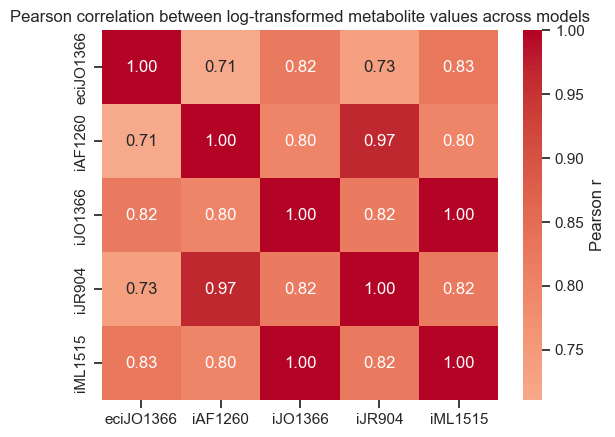

In [ ]:
corr_matrix = corr_df.pivot(index='Model 1', columns='Model 2', values='Pearson r')
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0.5, cbar_kws={'label': 'Pearson r'})
plt.title('Pearson correlation between log-transformed metabolite values across models')
plt.ylabel('')
plt.xlabel('')

plt.savefig(git_folder / 'figures' / 'ecoli_models_metabolite_values_correlation_matrix.pdf', bbox_inches='tight')
plt.savefig(git_folder / 'figures' / 'ecoli_models_metabolite_values_correlation_matrix.png', bbox_inches='tight', dpi=300)


Text(0.01, 0.94, 'p=0.05')

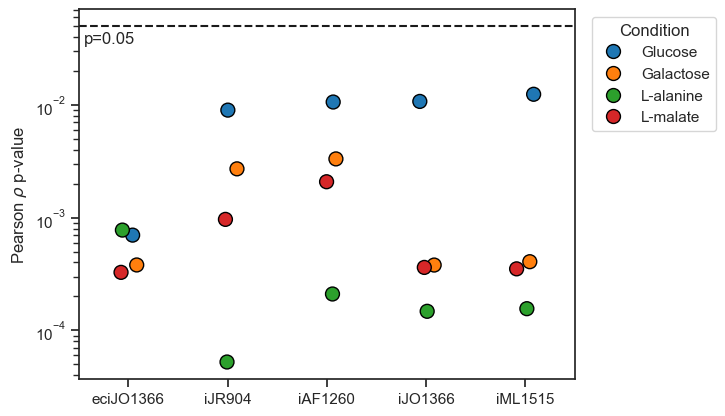

In [ ]:
fit_df = pd.DataFrame(fit_data)
l = sns.stripplot(data=fit_df, x='Model', y='pearson_p', hue='Condition', palette='tab10', order=model_order, s = 10, edgecolor='black', linewidth=1)
sns.move_legend(l, 'upper right', bbox_to_anchor=(1.3, 1), title='Condition')
plt.yscale('log')
plt.ylabel(r'Pearson $\rho$ p-value')
plt.xlabel('')
plt.axhline(0.05, color='k', linestyle='--', label='p=0.05')
plt.annotate('p=0.05', xy=(0.01, 0.94), xycoords='axes fraction', ha='left', va='top', fontsize=12)

Text(0.01, 0.94, 'p=0.05')

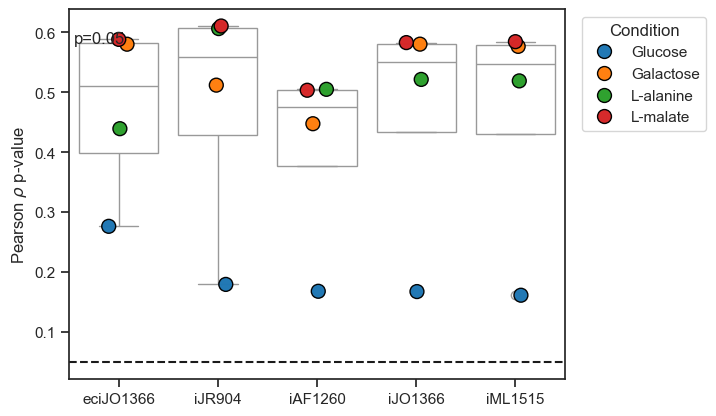

In [ ]:
fit_df['rsquared'] = fit_df['rvalue'] ** 2
# l = sns.boxplot(data=fit_df, x='Model', y='rsquared', hue='Condition', palette='tab10', order=model_order)
l = sns.boxplot(data=fit_df, x='Model', y='rsquared', order=model_order, color='w', linewidth=1)
sns.stripplot(data=fit_df, x='Model', y='rsquared', hue='Condition', palette='tab10', order=model_order, ax = l, s = 10, alpha=0.99, edgecolor='black', linewidth=1)
sns.move_legend(l, 'upper right', bbox_to_anchor=(1.3, 1), title='Condition')
# plt.yscale('log')
plt.ylabel(r'Pearson $\rho$ p-value')
plt.xlabel('')
plt.axhline(0.05, color='k', linestyle='--', label='p=0.05')
plt.annotate('p=0.05', xy=(0.01, 0.94), xycoords='axes fraction', ha='left', va='top', fontsize=12)

In [ ]:
df_rates['log10(Rate [mmol/gDW/h])']

15    -3.490488
33    -3.490488
42    -0.690957
43    -0.211787
44     0.325205
         ...   
768   -1.881353
806   -5.649638
808         NaN
809   -4.215253
824   -4.191032
Name: log10(Rate [mmol/gDW/h]), Length: 133, dtype: float64

In [ ]:
shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_r_1714':(glucose_uptake, 0)},
                                                        metabolites = measured_metabolites)

NameError: name 'leakage_reframed' is not defined

In [ ]:
for (cs, species) in conditions:
    print(cs, species)
    model_fn = model_fns[species]
    model = reframed.load_cbmodel(model_fn)
    ex_id = cs_to_exchange[species][cs]
    
    break

Glucose E. coli
